In [17]:
##Section A: Data Preparation (Loading and Shuffling Data)##
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load and Shuffle the Dataset
fake_news = pd.read_csv("Fake.csv")
real_news = pd.read_csv("True.csv")

fake_news["label"] = "Fake"
real_news["label"] = "Real"

df = pd.concat([fake_news, real_news], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
##Section B: Class Distributions and Probabilities##
# Class Distributions
class_counts = df["label"].value_counts()
class_probs = class_counts / len(df)

class_distribution = pd.DataFrame({
    "Class": class_counts.index,
    "Instances": class_counts.values,
    "Probability": class_probs.values
})

print(class_distribution)

  Class  Instances  Probability
0  Fake      23481     0.522985
1  Real      21417     0.477015


In [22]:
##Section C: Train-Test Split and Confirmation##
# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

# Confirm Train-Test Split Worked
print(f"Total dataset size: {len(df)}")
print(f"Training set size: {len(train_texts)}")
print(f"Testing set size: {len(test_texts)}")

print("Training set label distribution:")
print(pd.Series(train_labels).value_counts(normalize=True))

print("Testing set label distribution:")
print(pd.Series(test_labels).value_counts(normalize=True))

Total dataset size: 44898
Training set size: 35918
Testing set size: 8980
Training set label distribution:
Fake    0.522607
Real    0.477393
Name: label, dtype: float64
Testing set label distribution:
Fake    0.524499
Real    0.475501
Name: label, dtype: float64


In [20]:
##Section D: Text Vectorization##
# Text Vectorization
vectorizer = CountVectorizer(stop_words="english")

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

print(f"Number of features (words): {len(vectorizer.get_feature_names_out())}")
print("Sample feature words:", vectorizer.get_feature_names_out()[:10])

Number of features (words): 111194
Sample feature words: ['00' '000' '0000' '00004' '000048' '000063' '00007' '000270' '00042'
 '0005']


        Word  Frequency  Probability
0      trump     107102     0.013595
1       said     106104     0.013468
2  president      44411     0.005637
3     people      33446     0.004245
4      state      27328     0.003469


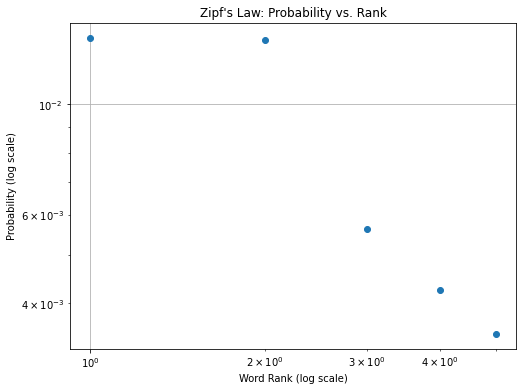

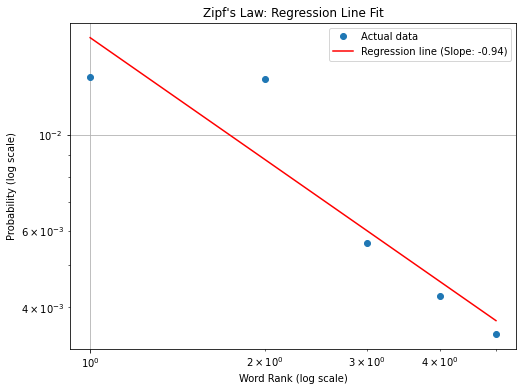

Regression Slope: -0.94


In [21]:
##Section E: Zipf's Law Analysis##
# Term Probabilities & Zipf’s Law
word_counts = np.asarray(X_train.sum(axis=0)).flatten()
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts))

sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:5]

word_df = pd.DataFrame(sorted_words, columns=["Word", "Frequency"])
word_df["Probability"] = word_df["Frequency"] / sum(word_counts)

print(word_df)

# Zipf’s Law Log-Log Plot
ranks = np.arange(1, len(sorted_words) + 1)
probs = word_df["Probability"]

plt.figure(figsize=(8, 6))
plt.loglog(ranks, probs, marker="o", linestyle="none")
plt.xlabel("Word Rank (log scale)")
plt.ylabel("Probability (log scale)")
plt.title("Zipf's Law: Probability vs. Rank")
plt.grid(True)
plt.show()

# Regression Line Fit
log_ranks = np.log(ranks).reshape(-1, 1)
log_probs = np.log(probs).values.reshape(-1, 1)

model = LinearRegression()
model.fit(log_ranks, log_probs)
slope = model.coef_[0][0]

plt.figure(figsize=(8, 6))
plt.loglog(ranks, probs, marker="o", linestyle="none", label="Actual data")
plt.plot(ranks, np.exp(model.predict(log_ranks)), label=f"Regression line (Slope: {slope:.2f})", color="red")
plt.xlabel("Word Rank (log scale)")
plt.ylabel("Probability (log scale)")
plt.title("Zipf's Law: Regression Line Fit")
plt.legend()
plt.grid(True)
plt.show()

print(f"Regression Slope: {slope:.2f}")

In [23]:
##Section F: Copnditional Probabilities of Two Words##
# Conditional Probabilities
fake_counts = X_train[np.array(train_labels) == "Fake"].sum(axis=0)
real_counts = X_train[np.array(train_labels) == "Real"].sum(axis=0)

word_to_index = {word: i for i, word in enumerate(vectorizer.get_feature_names_out())}

fake_word_index = np.argmax(fake_counts)
fake_word = vectorizer.get_feature_names_out()[fake_word_index]

real_word_index = np.argmax(real_counts)
real_word = vectorizer.get_feature_names_out()[real_word_index]

print(f"Top Fake News word: {fake_word}")
print(f"Top Real News word: {real_word}")

fake_word_idx = word_to_index[fake_word]
real_word_idx = word_to_index[real_word]

p_fake_given_fake = fake_counts[0, fake_word_idx] / np.sum(fake_counts)
p_fake_given_real = real_counts[0, fake_word_idx] / np.sum(real_counts)
p_real_given_fake = fake_counts[0, real_word_idx] / np.sum(fake_counts)
p_real_given_real = real_counts[0, real_word_idx] / np.sum(real_counts)

print(f"P({fake_word} | Fake News) = {p_fake_given_fake:.4f}")
print(f"P({fake_word} | Real News) = {p_fake_given_real:.4f}")
print(f"P({real_word} | Fake News) = {p_real_given_fake:.4f}")
print(f"P({real_word} | Real News) = {p_real_given_real:.4f}")

Top Fake News word: trump
Top Real News word: said
P(trump | Fake News) = 0.0151
P(trump | Real News) = 0.0119
P(said | Fake News) = 0.0064
P(said | Real News) = 0.0214


In [24]:
##Section G: Machine Learning Models##

##Naive Bayes Model##
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, train_labels)

y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(test_labels, y_pred)
conf_matrix = confusion_matrix(test_labels, y_pred)
report = classification_report(test_labels, y_pred)

print(f"Naive Bayes Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

##SVM Model##
svm_model = LinearSVC()
svm_model.fit(X_train, train_labels)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(test_labels, y_pred_svm)
conf_matrix_svm = confusion_matrix(test_labels, y_pred_svm)
report_svm = classification_report(test_labels, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.4f}")
print("Confusion Matrix (SVM):")
print(conf_matrix_svm)
print("\nClassification Report (SVM):")
print(report_svm)

##Decision Tree Model##
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, train_labels)

y_pred_dt = dt_model.predict(X_test)

accuracy_dt = accuracy_score(test_labels, y_pred_dt)
conf_matrix_dt = confusion_matrix(test_labels, y_pred_dt)
report_dt = classification_report(test_labels, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print("Confusion Matrix (Decision Tree):")
print(conf_matrix_dt)
print("\nClassification Report (Decision Tree):")
print(report_dt)

Naive Bayes Accuracy: 0.9486
Confusion Matrix:
[[4465  245]
 [ 217 4053]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      4710
        Real       0.94      0.95      0.95      4270

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Accuracy: 0.9952
Confusion Matrix (SVM):
[[4687   23]
 [  20 4250]]

Classification Report (SVM):
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4710
        Real       0.99      1.00      0.99      4270

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Decision Tree Accuracy: 0.9951
Confusion Matrix (Decision Tree):
[[4693   17]
 [  27 4243]]

Classification Report (Decision Tree):
              precision    recall  f1-score   support

        Fake       0.99      1.00      1.00      4710
        Real       1.00      0.99      0.99      4270

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [25]:
# Create a DataFrame to compare model performance
model_comparison = pd.DataFrame({
    "Model": ["Naive Bayes", "SVM (Linear)", "Decision Tree"],
    "Accuracy": [accuracy, accuracy_svm, accuracy_dt],
    "Misclassified Samples": [
        (conf_matrix[0,1] + conf_matrix[1,0]),
        (conf_matrix_svm[0,1] + conf_matrix_svm[1,0]),
        (conf_matrix_dt[0,1] + conf_matrix_dt[1,0])
    ],
    "Precision (Fake)": [
        report.split("\n")[2].split()[1],  # Extracts precision for Fake class
        report_svm.split("\n")[2].split()[1],
        report_dt.split("\n")[2].split()[1]
    ],
    "Recall (Fake)": [
        report.split("\n")[2].split()[2],  # Extracts recall for Fake class
        report_svm.split("\n")[2].split()[2],
        report_dt.split("\n")[2].split()[2]
    ],
    "F1-Score (Fake)": [
        report.split("\n")[2].split()[3],  # Extracts F1-score for Fake class
        report_svm.split("\n")[2].split()[3],
        report_dt.split("\n")[2].split()[3]
    ]
})

# Print the comparison table
print(model_comparison)

           Model  Accuracy  Misclassified Samples Precision (Fake)  \
0    Naive Bayes  0.948552                    462             0.95   
1   SVM (Linear)  0.995212                     43             1.00   
2  Decision Tree  0.995100                     44             0.99   

  Recall (Fake) F1-Score (Fake)  
0          0.95            0.95  
1          1.00            1.00  
2          1.00            1.00  
